### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 126 elements
My custom valing-dataset has 42 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

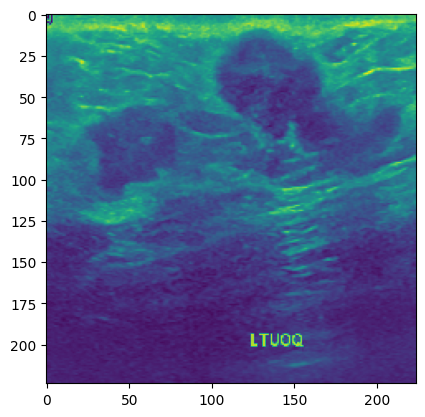

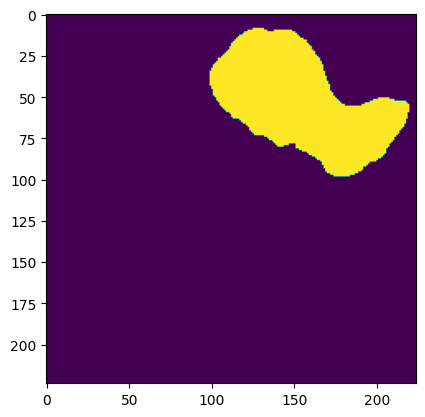

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_seg_models.FCN.models.segmentation.fcn import fcn_resnet101

model = fcn_resnet101(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCN'
data_name = 'malignant'

# 5. Training

 Epoch: 1 of 100, Iter.: 16 of 16, Train Loss: 1.388477, IoU: 0.337889, Dice: 0.463669
 Epoch: 1 of 100, Iter.: 16 of 16, Valid Loss: 1.723110, IoU: 0.303969, Dice: 0.434145

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


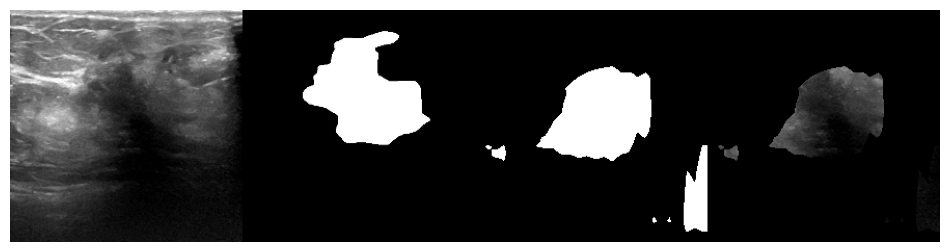

 Epoch: 2 of 100, Iter.: 16 of 16, Train Loss: 0.818069, IoU: 0.512534, Dice: 0.644115
 Epoch: 2 of 100, Iter.: 16 of 16, Valid Loss: 0.804808, IoU: 0.437447, Dice: 0.565217


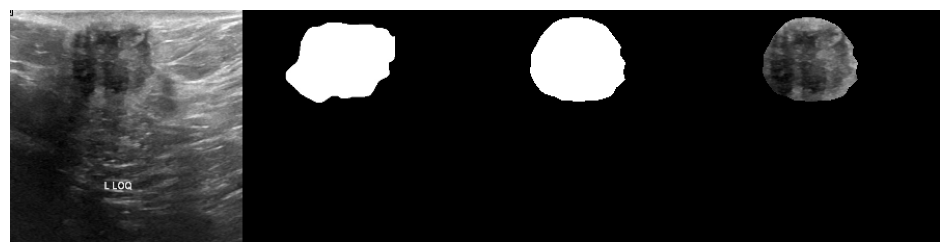

 Epoch: 3 of 100, Iter.: 16 of 16, Train Loss: 0.507108, IoU: 0.607764, Dice: 0.726963
 Epoch: 3 of 100, Iter.: 16 of 16, Valid Loss: 0.710201, IoU: 0.459009, Dice: 0.588423


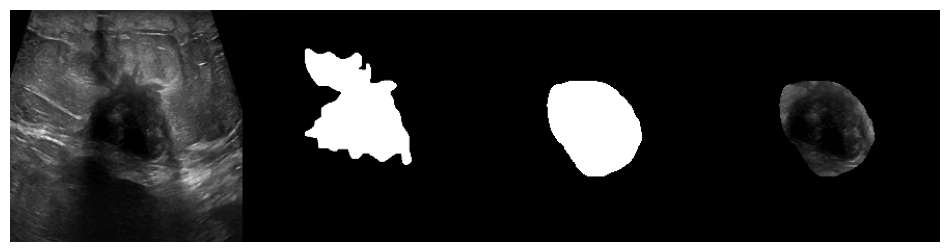

 Epoch: 4 of 100, Iter.: 16 of 16, Train Loss: 0.422587, IoU: 0.679031, Dice: 0.790441
 Epoch: 4 of 100, Iter.: 16 of 16, Valid Loss: 0.730777, IoU: 0.369099, Dice: 0.475374


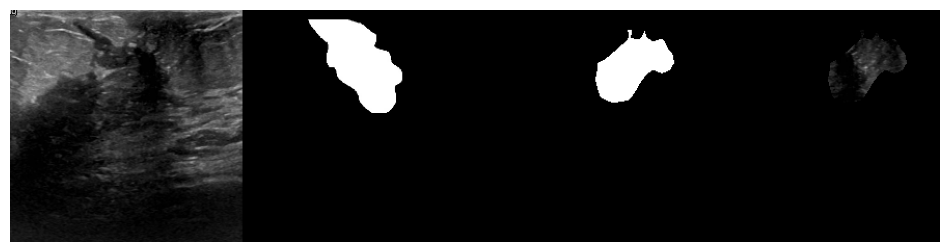

 Epoch: 5 of 100, Iter.: 16 of 16, Train Loss: 0.344024, IoU: 0.719586, Dice: 0.820178
 Epoch: 5 of 100, Iter.: 16 of 16, Valid Loss: 0.765911, IoU: 0.356862, Dice: 0.454346


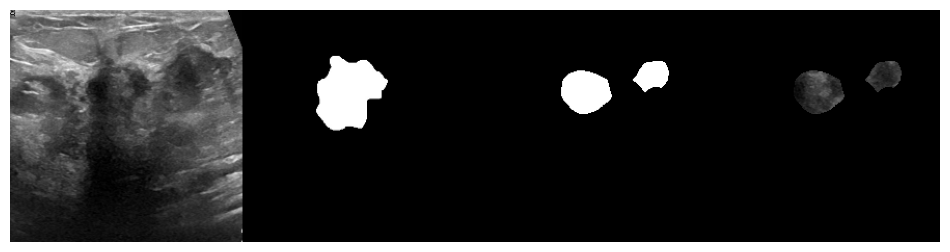

 Epoch: 6 of 100, Iter.: 16 of 16, Train Loss: 0.293840, IoU: 0.748629, Dice: 0.841321
 Epoch: 6 of 100, Iter.: 16 of 16, Valid Loss: 0.622970, IoU: 0.503361, Dice: 0.622717


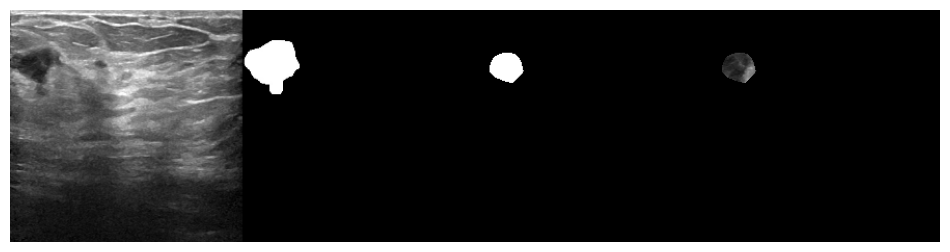

 Epoch: 7 of 100, Iter.: 16 of 16, Train Loss: 0.250316, IoU: 0.788219, Dice: 0.873275
 Epoch: 7 of 100, Iter.: 16 of 16, Valid Loss: 0.556933, IoU: 0.547257, Dice: 0.663240


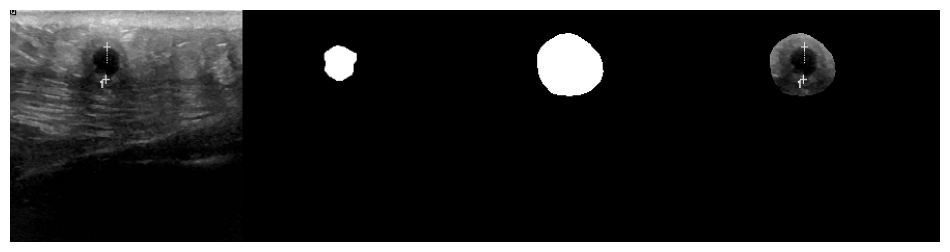

 Epoch: 8 of 100, Iter.: 16 of 16, Train Loss: 0.234893, IoU: 0.798141, Dice: 0.881742
 Epoch: 8 of 100, Iter.: 16 of 16, Valid Loss: 0.578422, IoU: 0.534516, Dice: 0.643191


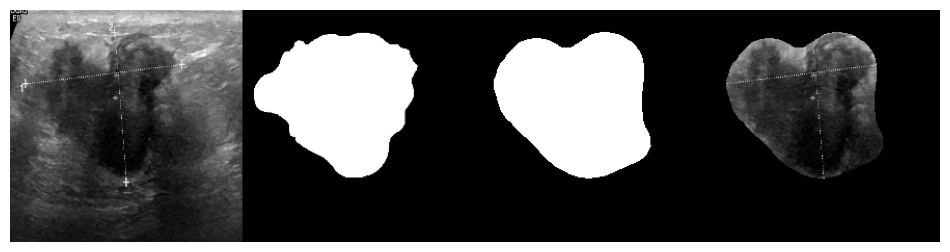

 Epoch: 9 of 100, Iter.: 16 of 16, Train Loss: 0.211035, IoU: 0.809506, Dice: 0.889642
 Epoch: 9 of 100, Iter.: 16 of 16, Valid Loss: 0.576960, IoU: 0.546502, Dice: 0.661719


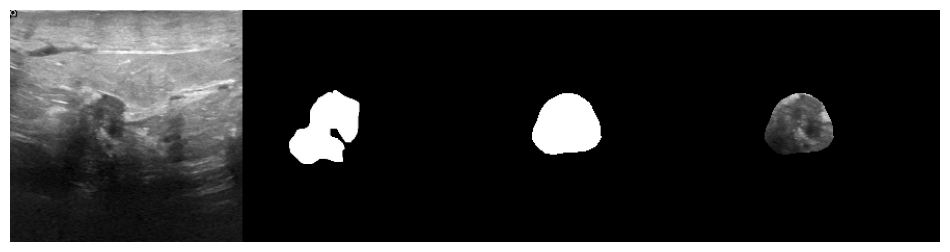

 Epoch: 10 of 100, Iter.: 16 of 16, Train Loss: 0.196436, IoU: 0.815329, Dice: 0.890050
 Epoch: 10 of 100, Iter.: 16 of 16, Valid Loss: 0.565993, IoU: 0.544822, Dice: 0.661038


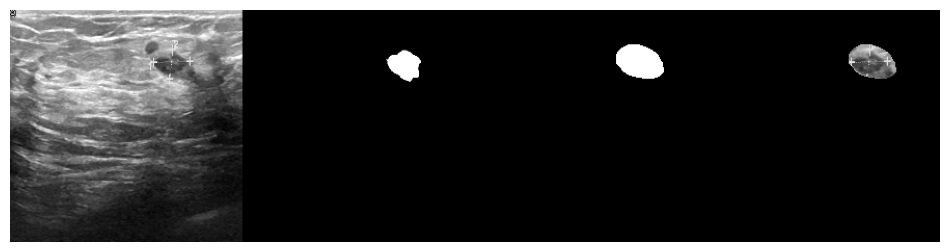

 Epoch: 11 of 100, Iter.: 16 of 16, Train Loss: 0.184935, IoU: 0.825341, Dice: 0.896147
 Epoch: 11 of 100, Iter.: 16 of 16, Valid Loss: 0.570342, IoU: 0.537135, Dice: 0.652634


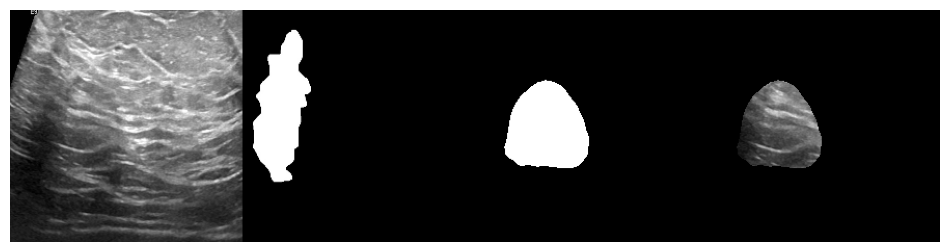

 Epoch: 12 of 100, Iter.: 16 of 16, Train Loss: 0.175104, IoU: 0.842314, Dice: 0.912481
 Epoch: 12 of 100, Iter.: 16 of 16, Valid Loss: 0.593682, IoU: 0.526305, Dice: 0.641660


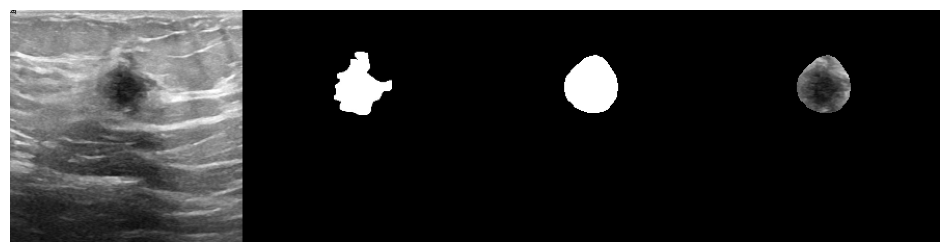

 Epoch: 13 of 100, Iter.: 16 of 16, Train Loss: 0.172895, IoU: 0.839377, Dice: 0.908612
 Epoch: 13 of 100, Iter.: 16 of 16, Valid Loss: 0.545281, IoU: 0.553387, Dice: 0.672799


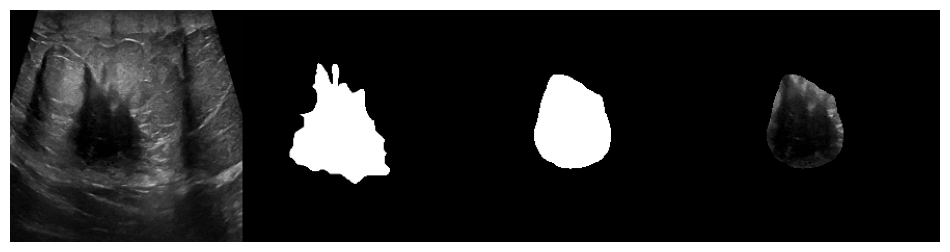

 Epoch: 14 of 100, Iter.: 16 of 16, Train Loss: 0.163928, IoU: 0.841101, Dice: 0.909983
 Epoch: 14 of 100, Iter.: 16 of 16, Valid Loss: 0.560283, IoU: 0.560750, Dice: 0.678198


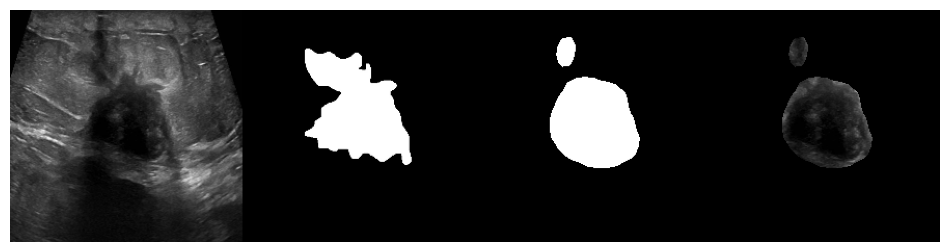

 Epoch: 15 of 100, Iter.: 16 of 16, Train Loss: 0.144333, IoU: 0.857330, Dice: 0.920848
 Epoch: 15 of 100, Iter.: 16 of 16, Valid Loss: 0.569934, IoU: 0.549984, Dice: 0.669836


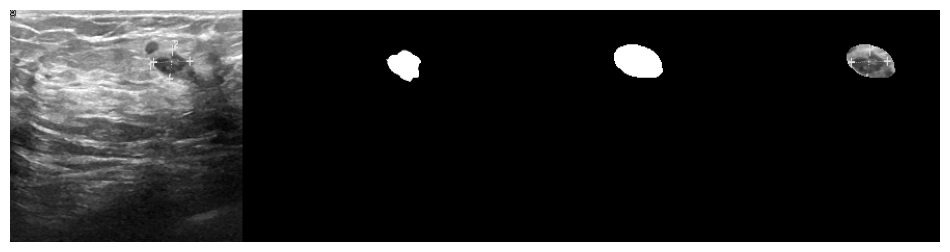

 Epoch: 16 of 100, Iter.: 16 of 16, Train Loss: 0.143685, IoU: 0.858926, Dice: 0.921840
 Epoch: 16 of 100, Iter.: 16 of 16, Valid Loss: 0.534782, IoU: 0.573318, Dice: 0.690979


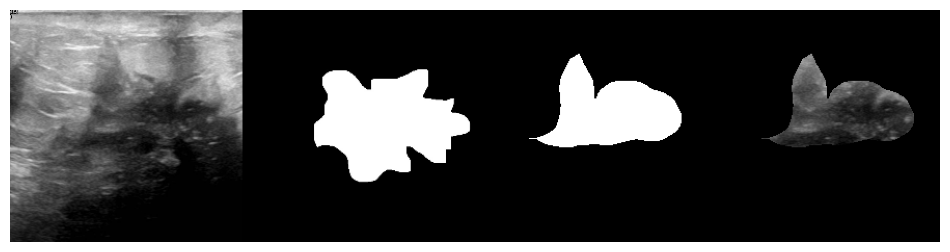

 Epoch: 17 of 100, Iter.: 16 of 16, Train Loss: 0.129811, IoU: 0.866956, Dice: 0.926885
 Epoch: 17 of 100, Iter.: 16 of 16, Valid Loss: 0.599937, IoU: 0.539833, Dice: 0.656175


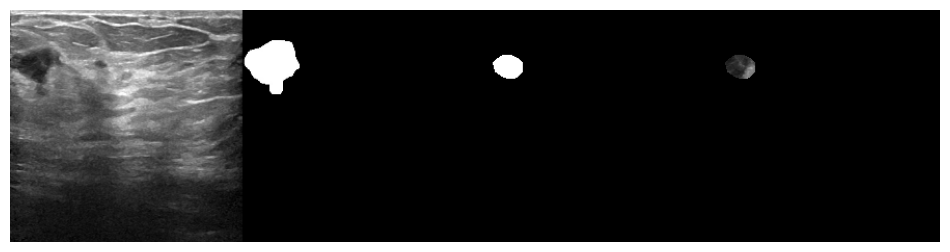

 Epoch: 18 of 100, Iter.: 16 of 16, Train Loss: 0.122277, IoU: 0.874679, Dice: 0.928756
 Epoch: 18 of 100, Iter.: 16 of 16, Valid Loss: 0.538623, IoU: 0.569679, Dice: 0.686344


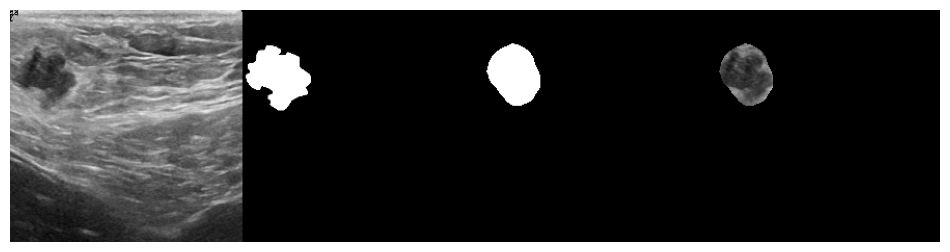

 Epoch: 19 of 100, Iter.: 16 of 16, Train Loss: 0.109910, IoU: 0.886453, Dice: 0.935698
 Epoch: 19 of 100, Iter.: 16 of 16, Valid Loss: 0.571722, IoU: 0.554678, Dice: 0.668385


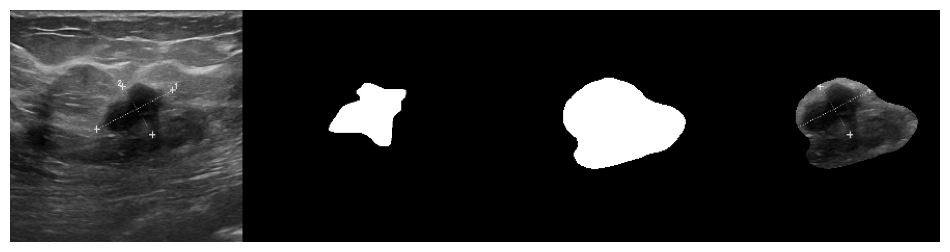

 Epoch: 20 of 100, Iter.: 16 of 16, Train Loss: 0.103933, IoU: 0.890004, Dice: 0.937932
 Epoch: 20 of 100, Iter.: 16 of 16, Valid Loss: 0.539798, IoU: 0.574657, Dice: 0.689196


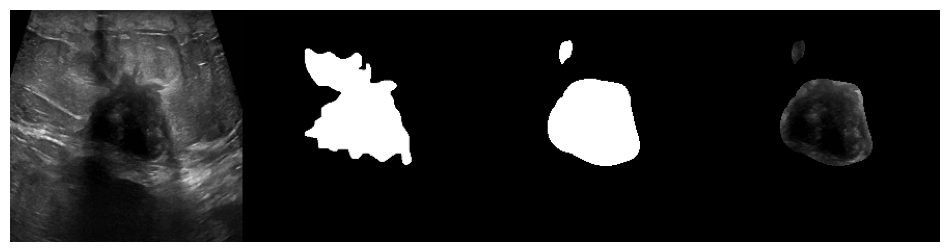

 Epoch: 21 of 100, Iter.: 16 of 16, Train Loss: 0.107366, IoU: 0.892278, Dice: 0.942226
 Epoch: 21 of 100, Iter.: 16 of 16, Valid Loss: 0.564547, IoU: 0.561034, Dice: 0.674982


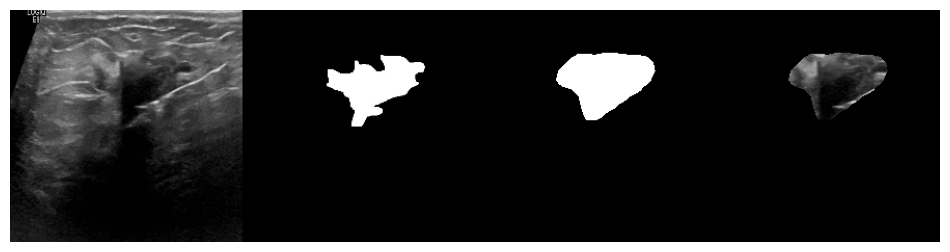

 Epoch: 22 of 100, Iter.: 16 of 16, Train Loss: 0.098852, IoU: 0.897968, Dice: 0.945613
 Epoch: 22 of 100, Iter.: 16 of 16, Valid Loss: 0.571164, IoU: 0.554219, Dice: 0.670430


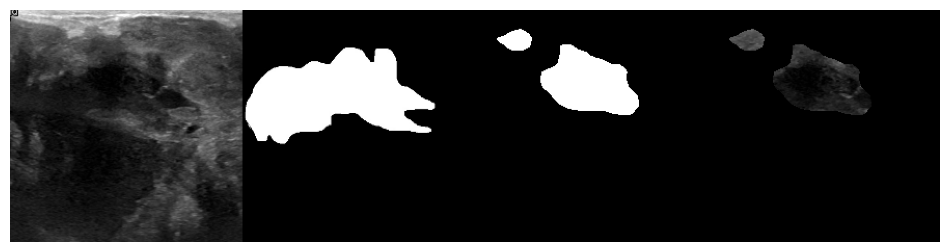

 Epoch: 23 of 100, Iter.: 16 of 16, Train Loss: 0.095058, IoU: 0.903069, Dice: 0.948281
 Epoch: 23 of 100, Iter.: 16 of 16, Valid Loss: 0.564662, IoU: 0.570126, Dice: 0.684676


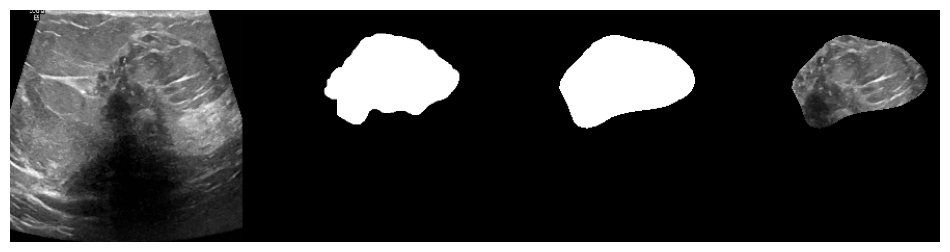

 Epoch: 24 of 100, Iter.: 16 of 16, Train Loss: 0.098408, IoU: 0.902093, Dice: 0.947824
 Epoch: 24 of 100, Iter.: 16 of 16, Valid Loss: 0.577049, IoU: 0.550777, Dice: 0.667967


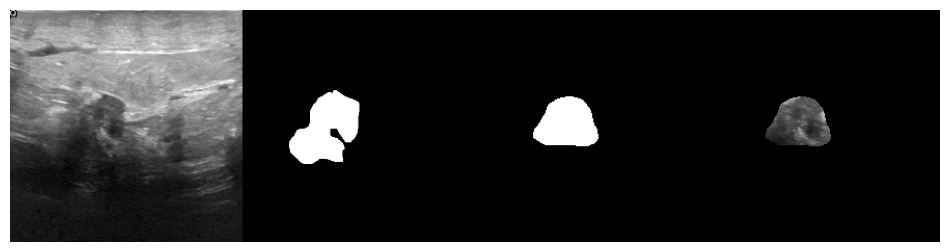

 Epoch: 25 of 100, Iter.: 16 of 16, Train Loss: 0.093069, IoU: 0.901635, Dice: 0.947416
 Epoch: 25 of 100, Iter.: 16 of 16, Valid Loss: 0.555407, IoU: 0.577670, Dice: 0.692816


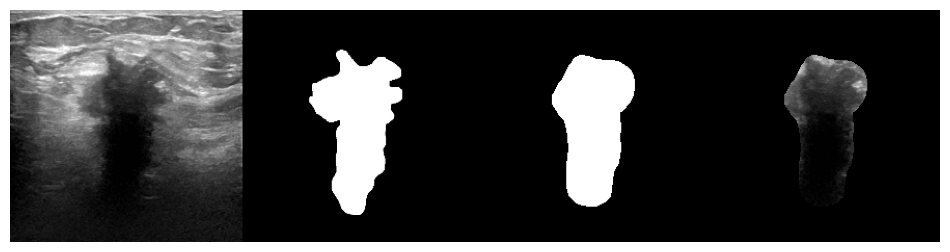

 Epoch: 26 of 100, Iter.: 16 of 16, Train Loss: 0.089676, IoU: 0.905691, Dice: 0.949977
 Epoch: 26 of 100, Iter.: 16 of 16, Valid Loss: 0.563899, IoU: 0.566644, Dice: 0.683880


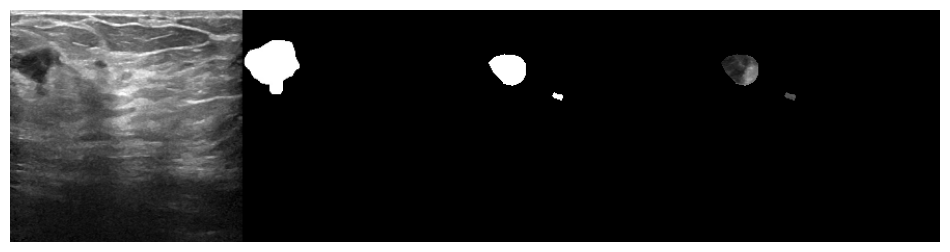

 Epoch: 27 of 100, Iter.: 16 of 16, Train Loss: 0.084119, IoU: 0.907064, Dice: 0.947323
 Epoch: 27 of 100, Iter.: 16 of 16, Valid Loss: 0.545523, IoU: 0.572000, Dice: 0.686582


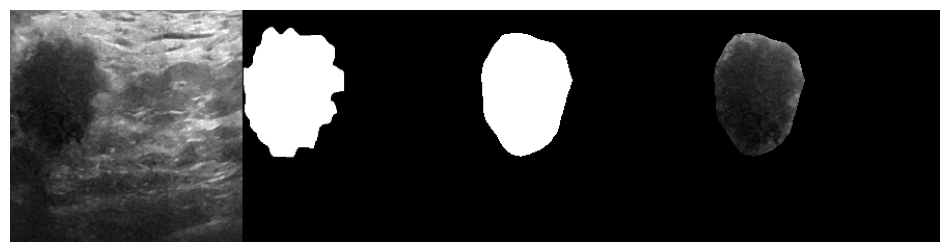

 Epoch: 28 of 100, Iter.: 16 of 16, Train Loss: 0.078733, IoU: 0.912267, Dice: 0.950247
 Epoch: 28 of 100, Iter.: 16 of 16, Valid Loss: 0.563835, IoU: 0.558919, Dice: 0.674982


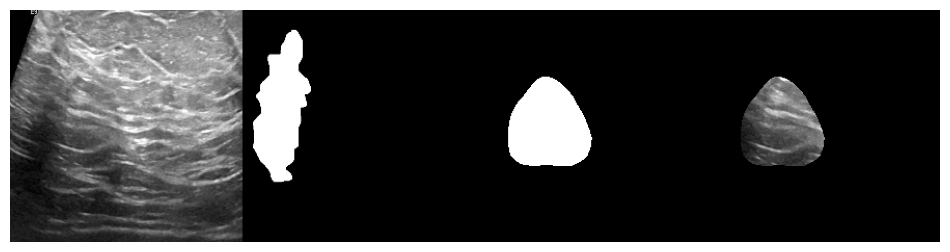

 Epoch: 29 of 100, Iter.: 16 of 16, Train Loss: 0.077633, IoU: 0.917332, Dice: 0.956432
 Epoch: 29 of 100, Iter.: 16 of 16, Valid Loss: 0.580704, IoU: 0.564412, Dice: 0.680924


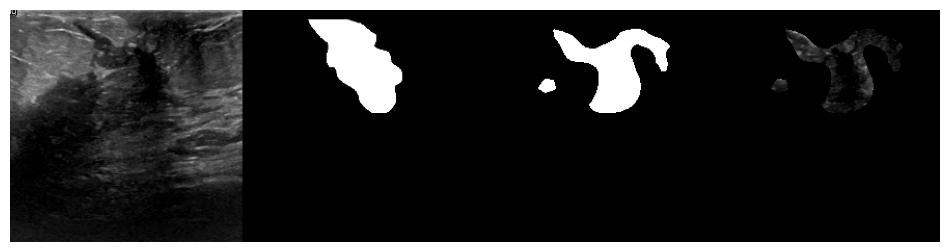

 Epoch: 30 of 100, Iter.: 16 of 16, Train Loss: 0.075271, IoU: 0.920437, Dice: 0.958034
 Epoch: 30 of 100, Iter.: 16 of 16, Valid Loss: 0.532590, IoU: 0.581247, Dice: 0.696584


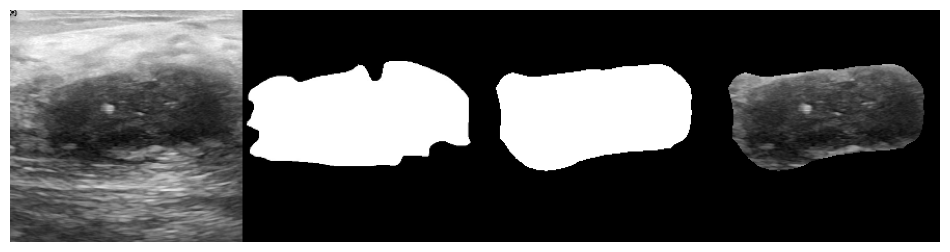

 Epoch: 31 of 100, Iter.: 16 of 16, Train Loss: 0.075905, IoU: 0.920598, Dice: 0.958238
 Epoch: 31 of 100, Iter.: 16 of 16, Valid Loss: 0.552016, IoU: 0.575187, Dice: 0.689303


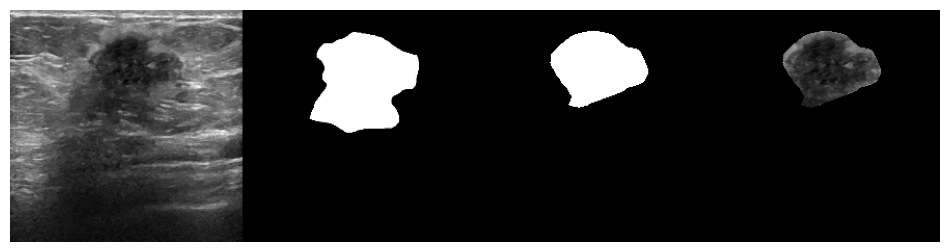

 Epoch: 32 of 100, Iter.: 16 of 16, Train Loss: 0.067804, IoU: 0.922155, Dice: 0.958670
 Epoch: 32 of 100, Iter.: 16 of 16, Valid Loss: 0.553236, IoU: 0.572113, Dice: 0.688383


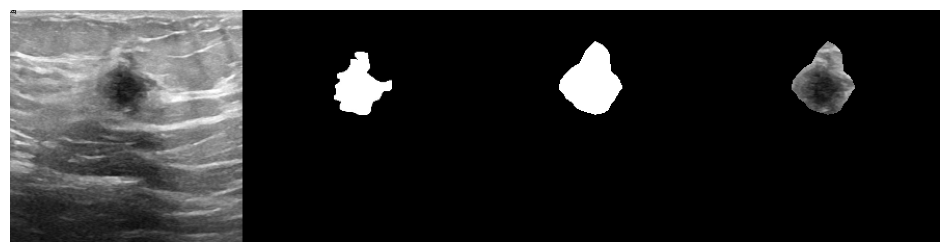

 Epoch: 33 of 100, Iter.: 16 of 16, Train Loss: 0.069899, IoU: 0.927246, Dice: 0.961833
 Epoch: 33 of 100, Iter.: 16 of 16, Valid Loss: 0.558521, IoU: 0.574431, Dice: 0.688390


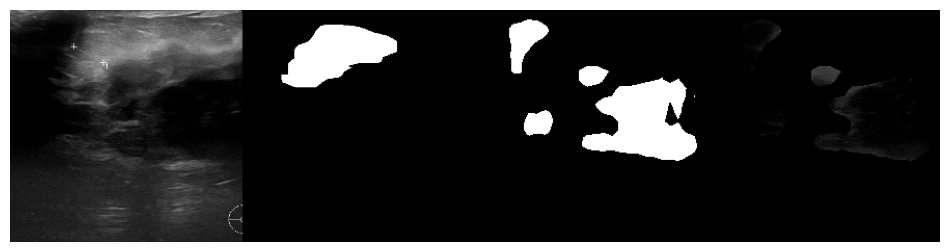

 Epoch: 34 of 100, Iter.: 16 of 16, Train Loss: 0.066123, IoU: 0.927542, Dice: 0.962036
 Epoch: 34 of 100, Iter.: 16 of 16, Valid Loss: 0.540981, IoU: 0.585914, Dice: 0.699328


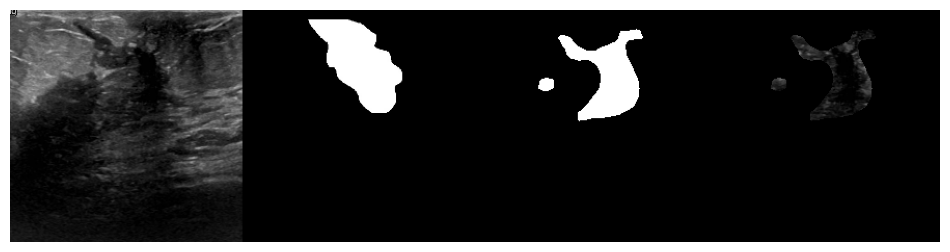

 Epoch: 35 of 100, Iter.: 16 of 16, Train Loss: 0.066905, IoU: 0.929778, Dice: 0.963281
 Epoch: 35 of 100, Iter.: 16 of 16, Valid Loss: 0.584902, IoU: 0.557589, Dice: 0.672115


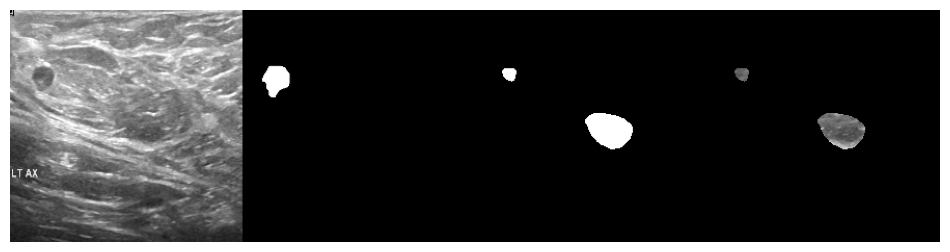

 Epoch: 36 of 100, Iter.: 16 of 16, Train Loss: 0.065915, IoU: 0.928521, Dice: 0.962582
 Epoch: 36 of 100, Iter.: 16 of 16, Valid Loss: 0.555170, IoU: 0.581248, Dice: 0.692658


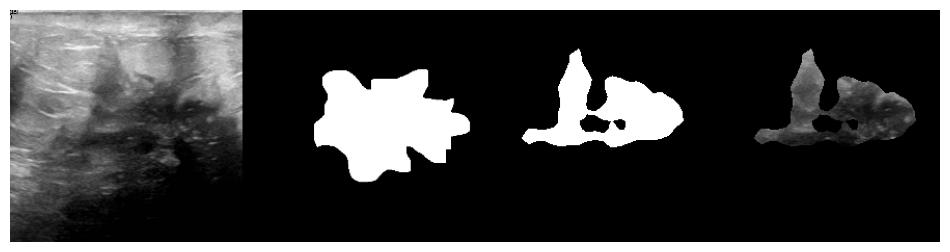

 Epoch: 37 of 100, Iter.: 16 of 16, Train Loss: 0.064511, IoU: 0.929409, Dice: 0.963057
 Epoch: 37 of 100, Iter.: 16 of 16, Valid Loss: 0.546748, IoU: 0.573579, Dice: 0.687817


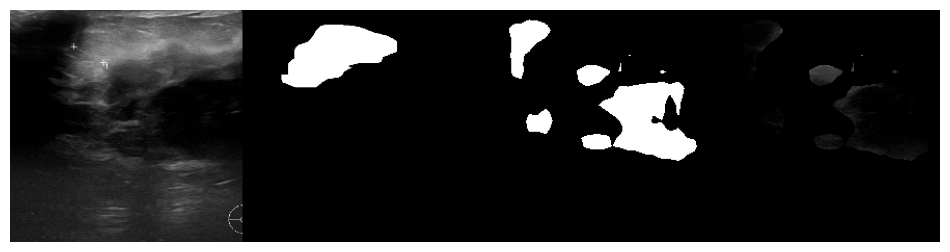

 Epoch: 38 of 100, Iter.: 16 of 16, Train Loss: 0.060148, IoU: 0.932689, Dice: 0.964820
 Epoch: 38 of 100, Iter.: 16 of 16, Valid Loss: 0.570294, IoU: 0.578655, Dice: 0.693540


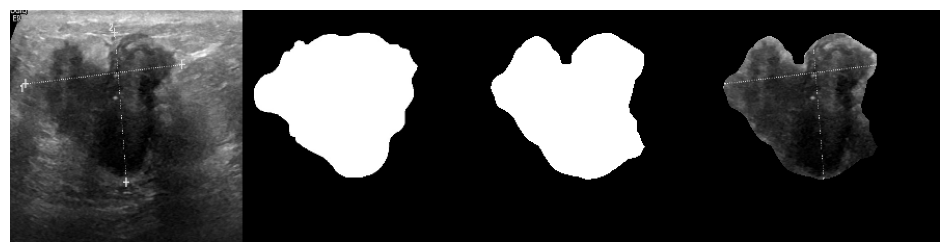

 Epoch: 39 of 100, Iter.: 16 of 16, Train Loss: 0.060548, IoU: 0.935073, Dice: 0.966131
 Epoch: 39 of 100, Iter.: 16 of 16, Valid Loss: 0.570277, IoU: 0.572168, Dice: 0.685532


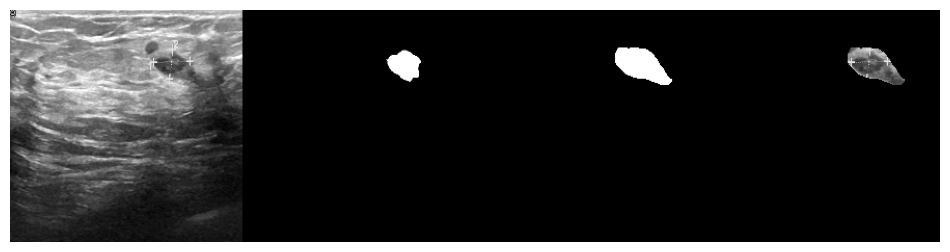

 Epoch: 40 of 100, Iter.: 16 of 16, Train Loss: 0.056275, IoU: 0.936898, Dice: 0.967117
 Epoch: 40 of 100, Iter.: 16 of 16, Valid Loss: 0.570715, IoU: 0.577659, Dice: 0.691034


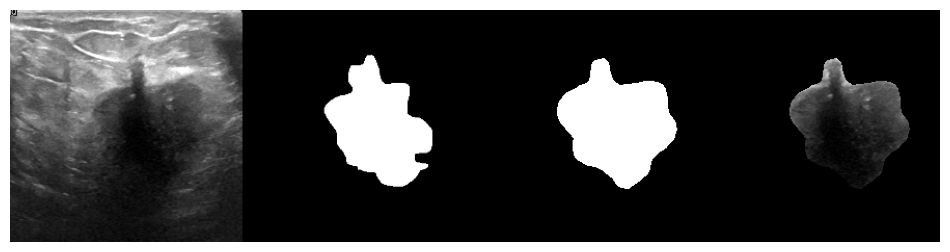

 Epoch: 41 of 100, Iter.: 16 of 16, Train Loss: 0.054931, IoU: 0.939489, Dice: 0.968539
 Epoch: 41 of 100, Iter.: 16 of 16, Valid Loss: 0.569747, IoU: 0.577809, Dice: 0.691260


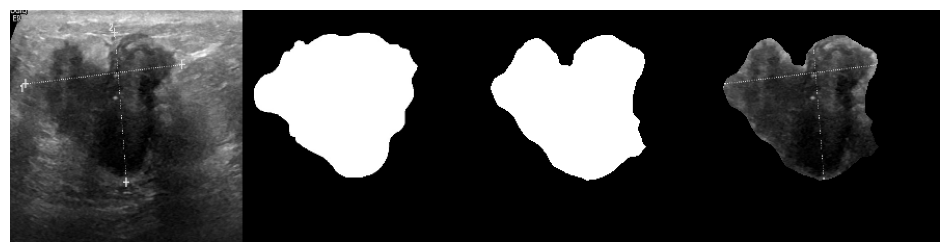

 Epoch: 42 of 100, Iter.: 16 of 16, Train Loss: 0.051943, IoU: 0.942984, Dice: 0.970397
 Epoch: 42 of 100, Iter.: 16 of 16, Valid Loss: 0.556154, IoU: 0.584126, Dice: 0.697320


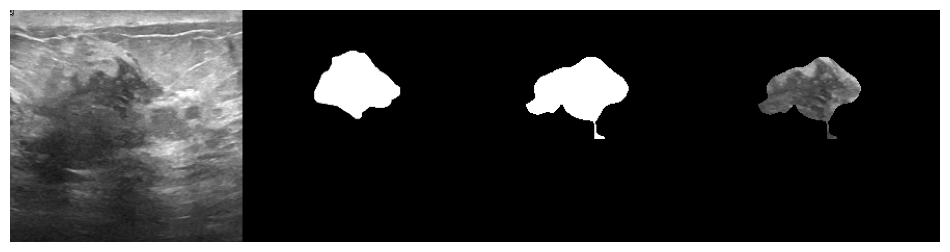

 Epoch: 43 of 100, Iter.: 16 of 16, Train Loss: 0.051876, IoU: 0.943836, Dice: 0.970853
 Epoch: 43 of 100, Iter.: 16 of 16, Valid Loss: 0.559678, IoU: 0.586661, Dice: 0.701618


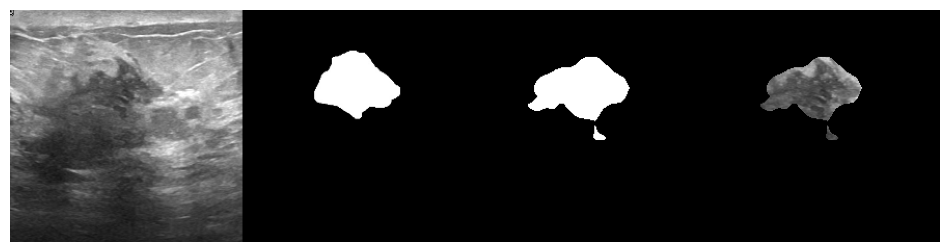

 Epoch: 44 of 100, Iter.: 16 of 16, Train Loss: 0.051216, IoU: 0.943215, Dice: 0.970451
 Epoch: 44 of 100, Iter.: 16 of 16, Valid Loss: 0.564565, IoU: 0.585651, Dice: 0.699186


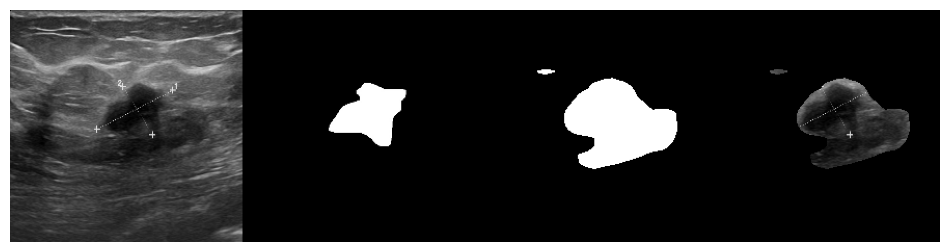

 Epoch: 45 of 100, Iter.: 16 of 16, Train Loss: 0.050188, IoU: 0.945038, Dice: 0.971529
 Epoch: 45 of 100, Iter.: 16 of 16, Valid Loss: 0.546603, IoU: 0.587855, Dice: 0.699392


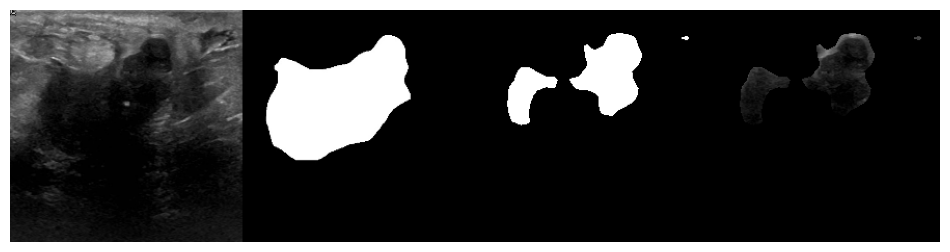

 Epoch: 46 of 100, Iter.: 16 of 16, Train Loss: 0.050245, IoU: 0.944554, Dice: 0.971235
 Epoch: 46 of 100, Iter.: 16 of 16, Valid Loss: 0.569795, IoU: 0.591177, Dice: 0.704263


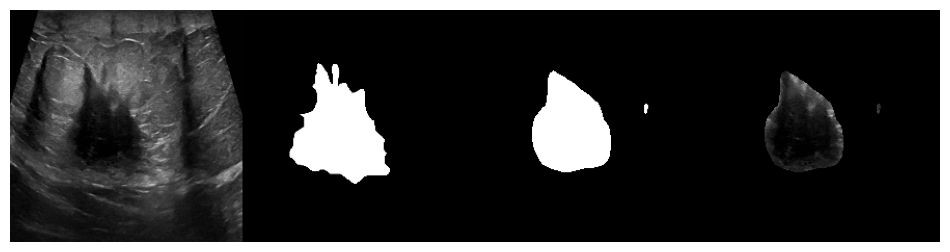

 Epoch: 47 of 100, Iter.: 16 of 16, Train Loss: 0.047265, IoU: 0.946027, Dice: 0.972046
 Epoch: 47 of 100, Iter.: 16 of 16, Valid Loss: 0.559461, IoU: 0.582879, Dice: 0.697523


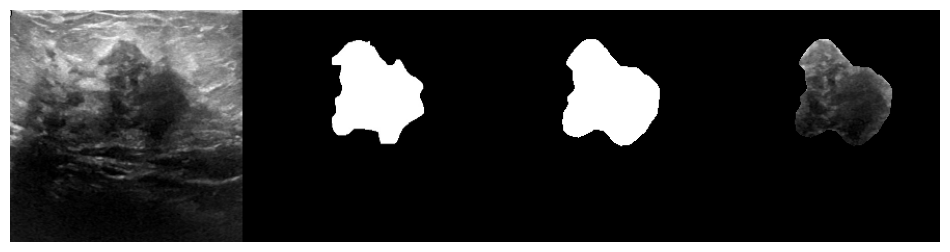

 Epoch: 48 of 100, Iter.: 16 of 16, Train Loss: 0.049426, IoU: 0.946859, Dice: 0.972533
 Epoch: 48 of 100, Iter.: 16 of 16, Valid Loss: 0.564945, IoU: 0.583354, Dice: 0.697128


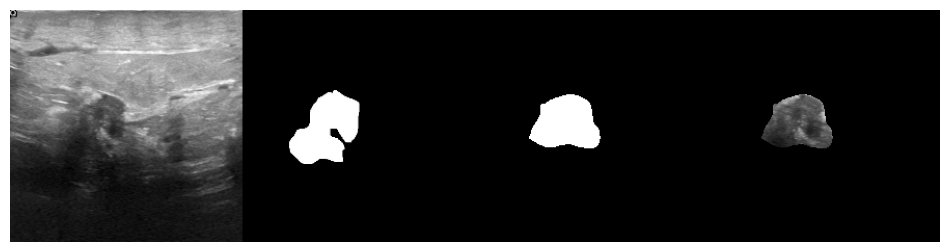

 Epoch: 49 of 100, Iter.: 16 of 16, Train Loss: 0.049046, IoU: 0.946113, Dice: 0.972088
 Epoch: 49 of 100, Iter.: 16 of 16, Valid Loss: 0.577697, IoU: 0.576982, Dice: 0.689998


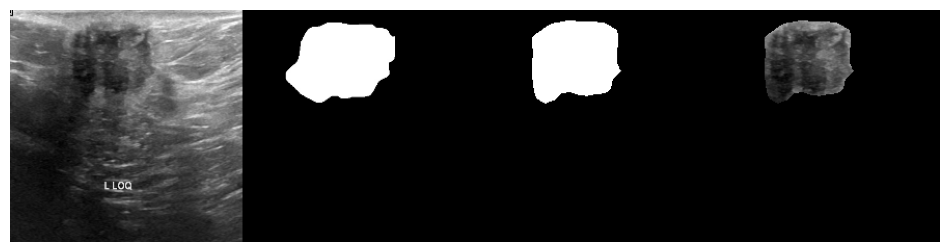

 Epoch: 50 of 100, Iter.: 16 of 16, Train Loss: 0.047029, IoU: 0.947904, Dice: 0.973047
 Epoch: 50 of 100, Iter.: 16 of 16, Valid Loss: 0.576437, IoU: 0.575768, Dice: 0.688642


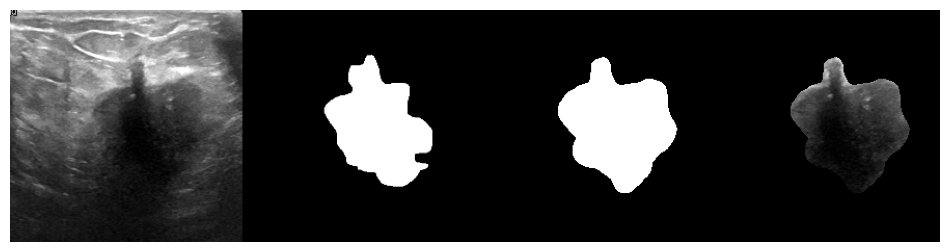

 Epoch: 51 of 100, Iter.: 16 of 16, Train Loss: 0.045004, IoU: 0.951238, Dice: 0.974855
 Epoch: 51 of 100, Iter.: 16 of 16, Valid Loss: 0.555470, IoU: 0.586147, Dice: 0.698587


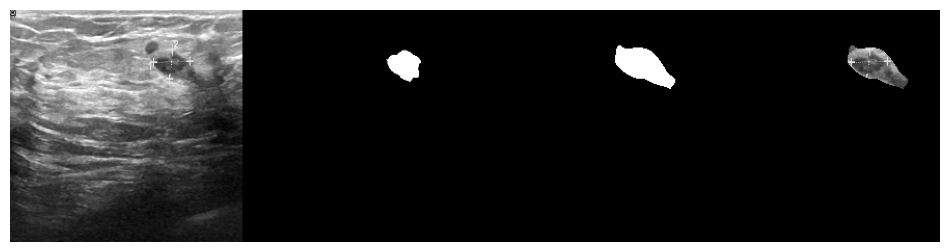

 Epoch: 52 of 100, Iter.: 16 of 16, Train Loss: 0.047052, IoU: 0.949570, Dice: 0.973857
 Epoch: 52 of 100, Iter.: 16 of 16, Valid Loss: 0.590258, IoU: 0.571841, Dice: 0.685184


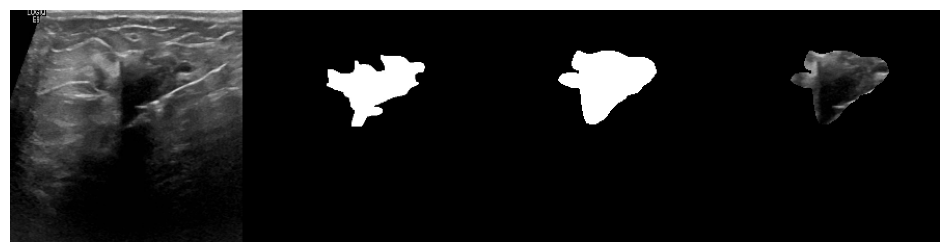

 Epoch: 53 of 100, Iter.: 16 of 16, Train Loss: 0.045252, IoU: 0.941748, Dice: 0.966067
 Epoch: 53 of 100, Iter.: 16 of 16, Valid Loss: 0.571300, IoU: 0.586423, Dice: 0.701540


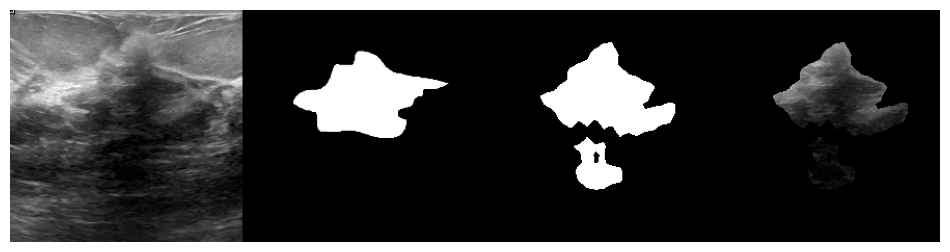

 Epoch: 54 of 100, Iter.: 16 of 16, Train Loss: 0.043673, IoU: 0.950405, Dice: 0.974392
 Epoch: 54 of 100, Iter.: 16 of 16, Valid Loss: 0.595436, IoU: 0.571316, Dice: 0.682925


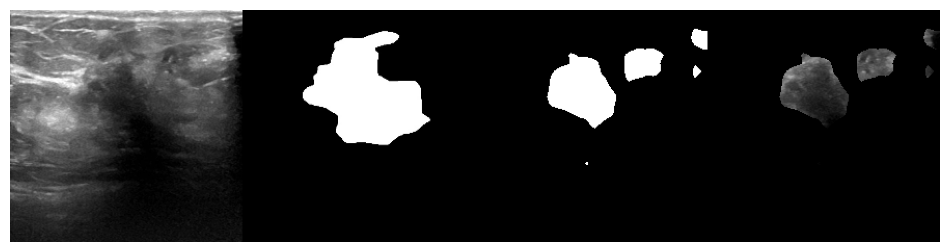

 Epoch: 55 of 100, Iter.: 16 of 16, Train Loss: 0.045340, IoU: 0.949003, Dice: 0.973575
 Epoch: 55 of 100, Iter.: 16 of 16, Valid Loss: 0.584448, IoU: 0.576478, Dice: 0.688729


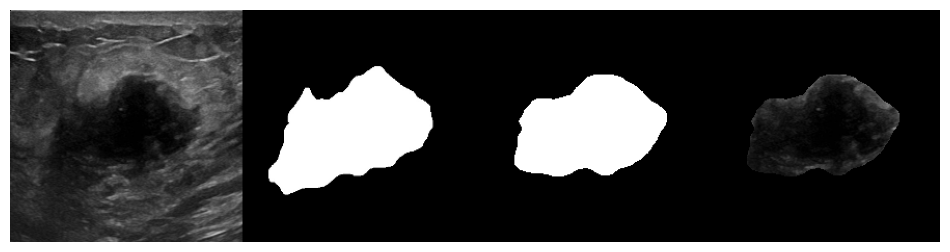

 Epoch: 56 of 100, Iter.: 16 of 16, Train Loss: 0.043733, IoU: 0.949539, Dice: 0.973793
 Epoch: 56 of 100, Iter.: 16 of 16, Valid Loss: 0.616101, IoU: 0.559525, Dice: 0.672888


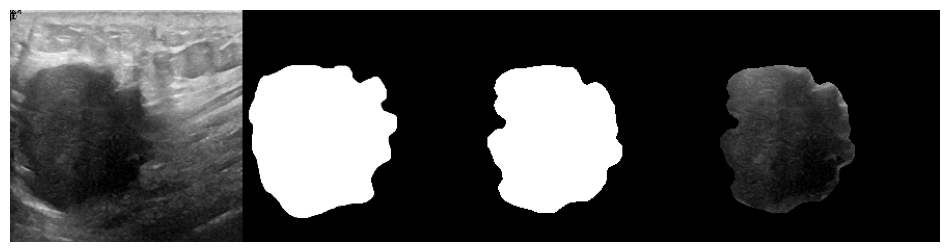

 Epoch: 57 of 100, Iter.: 16 of 16, Train Loss: 0.042087, IoU: 0.951210, Dice: 0.974709
 Epoch: 57 of 100, Iter.: 16 of 16, Valid Loss: 0.578551, IoU: 0.583338, Dice: 0.696424


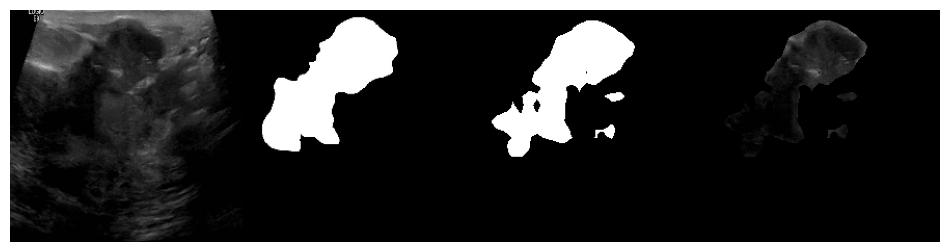

 Epoch: 58 of 100, Iter.: 16 of 16, Train Loss: 0.040446, IoU: 0.953256, Dice: 0.975866
 Epoch: 58 of 100, Iter.: 16 of 16, Valid Loss: 0.575510, IoU: 0.584372, Dice: 0.698371


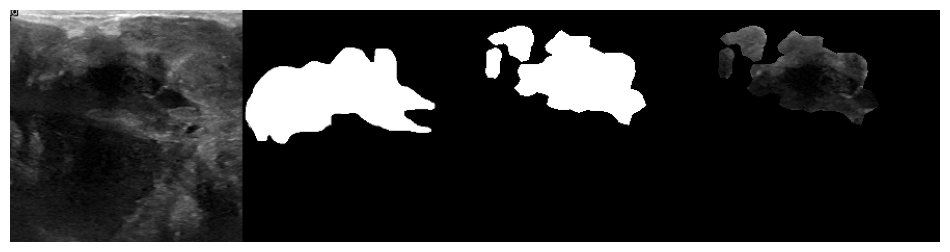

 Epoch: 59 of 100, Iter.: 16 of 16, Train Loss: 0.040114, IoU: 0.954677, Dice: 0.976619
 Epoch: 59 of 100, Iter.: 16 of 16, Valid Loss: 0.584778, IoU: 0.583905, Dice: 0.696366


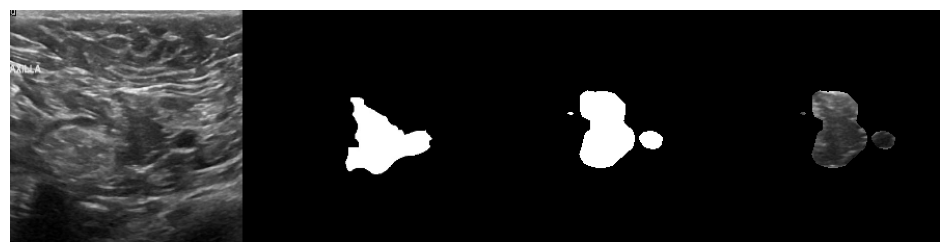

 Epoch: 60 of 100, Iter.: 16 of 16, Train Loss: 0.038988, IoU: 0.956916, Dice: 0.977812
 Epoch: 60 of 100, Iter.: 16 of 16, Valid Loss: 0.588882, IoU: 0.583030, Dice: 0.697194


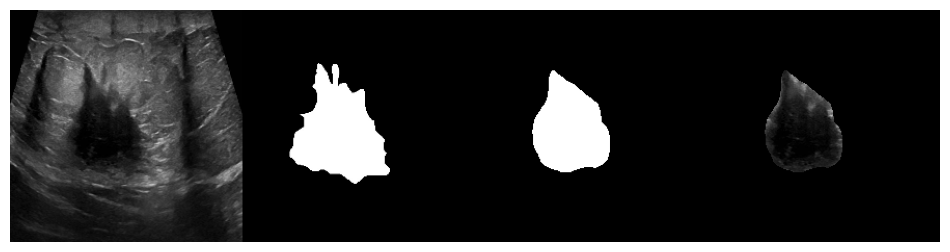

 Epoch: 61 of 100, Iter.: 16 of 16, Train Loss: 0.036748, IoU: 0.958014, Dice: 0.978416
 Epoch: 61 of 100, Iter.: 16 of 16, Valid Loss: 0.603107, IoU: 0.571422, Dice: 0.685396


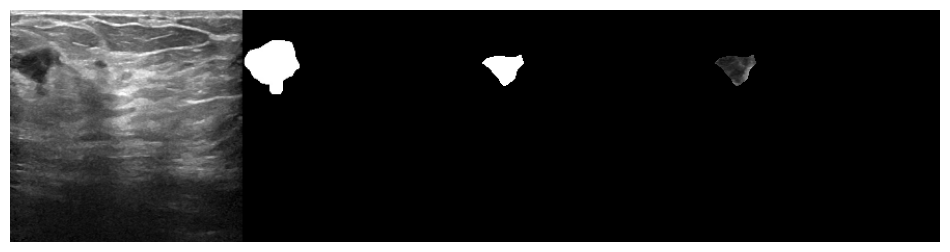

 Epoch: 62 of 100, Iter.: 16 of 16, Train Loss: 0.037871, IoU: 0.956744, Dice: 0.977674
 Epoch: 62 of 100, Iter.: 16 of 16, Valid Loss: 0.571644, IoU: 0.586537, Dice: 0.699201


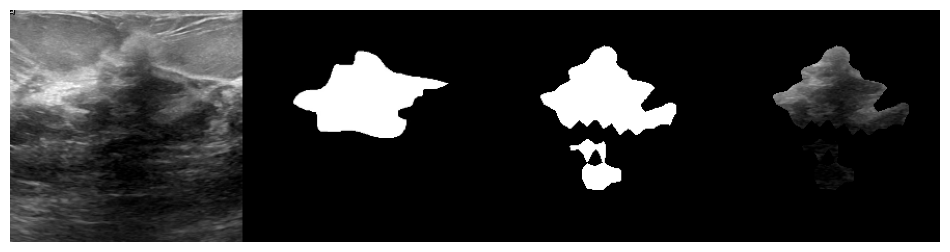

 Epoch: 63 of 100, Iter.: 16 of 16, Train Loss: 0.037202, IoU: 0.956926, Dice: 0.977830
 Epoch: 63 of 100, Iter.: 16 of 16, Valid Loss: 0.607110, IoU: 0.582189, Dice: 0.697239


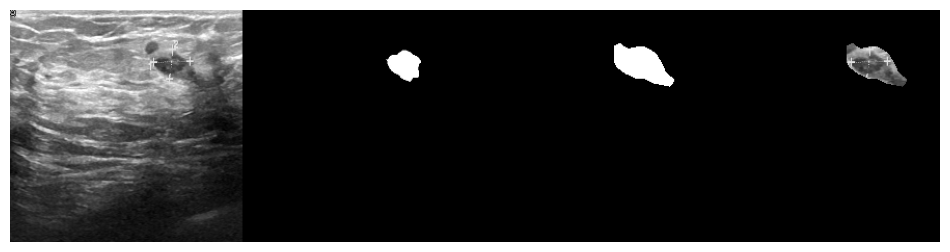

 Epoch: 64 of 100, Iter.: 16 of 16, Train Loss: 0.037874, IoU: 0.958047, Dice: 0.978444
 Epoch: 64 of 100, Iter.: 16 of 16, Valid Loss: 0.594944, IoU: 0.575126, Dice: 0.688986


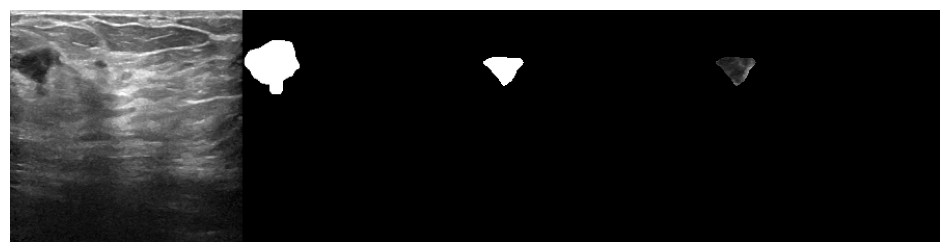

 Epoch: 65 of 100, Iter.: 16 of 16, Train Loss: 0.038145, IoU: 0.957170, Dice: 0.977957
 Epoch: 65 of 100, Iter.: 16 of 16, Valid Loss: 0.590833, IoU: 0.589438, Dice: 0.702980


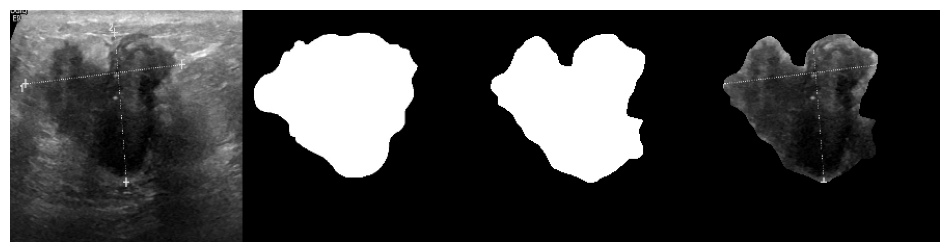

 Epoch: 66 of 100, Iter.: 16 of 16, Train Loss: 0.037038, IoU: 0.957784, Dice: 0.978272
 Epoch: 66 of 100, Iter.: 16 of 16, Valid Loss: 0.580556, IoU: 0.593808, Dice: 0.707641


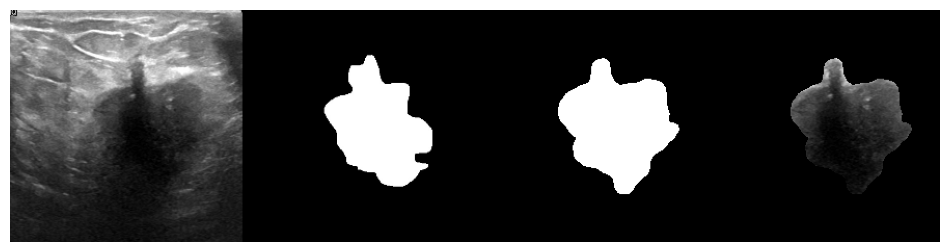

 Epoch: 67 of 100, Iter.: 16 of 16, Train Loss: 0.034718, IoU: 0.958742, Dice: 0.978769
 Epoch: 67 of 100, Iter.: 16 of 16, Valid Loss: 0.578721, IoU: 0.590873, Dice: 0.705539


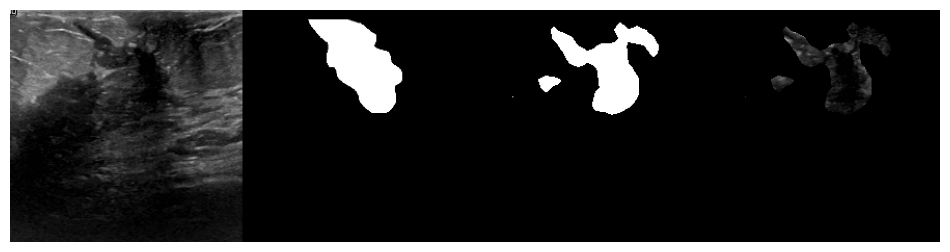

 Epoch: 68 of 100, Iter.: 16 of 16, Train Loss: 0.034430, IoU: 0.957384, Dice: 0.977497
 Epoch: 68 of 100, Iter.: 16 of 16, Valid Loss: 0.595539, IoU: 0.589276, Dice: 0.703456


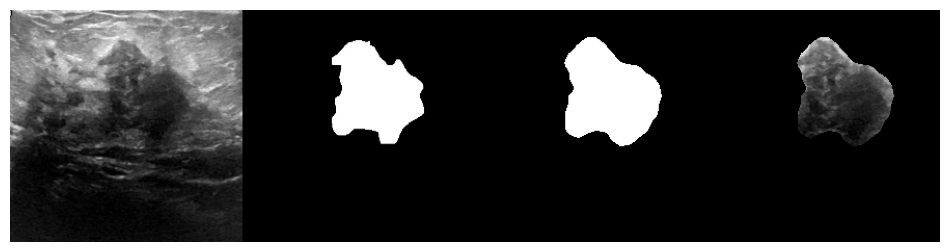

 Epoch: 69 of 100, Iter.: 16 of 16, Train Loss: 0.034495, IoU: 0.961248, Dice: 0.980111
 Epoch: 69 of 100, Iter.: 16 of 16, Valid Loss: 0.590733, IoU: 0.582138, Dice: 0.695432


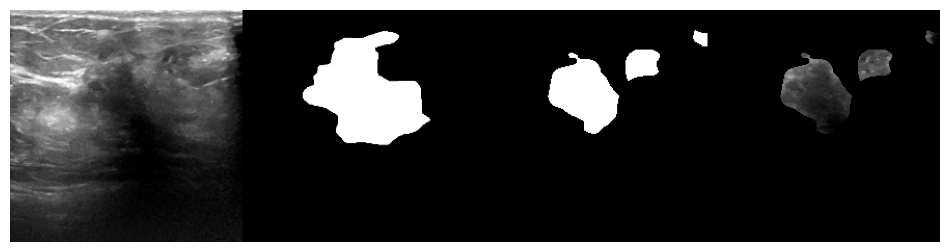

 Epoch: 70 of 100, Iter.: 16 of 16, Train Loss: 0.033814, IoU: 0.961082, Dice: 0.979971
 Epoch: 70 of 100, Iter.: 16 of 16, Valid Loss: 0.596593, IoU: 0.589867, Dice: 0.703669


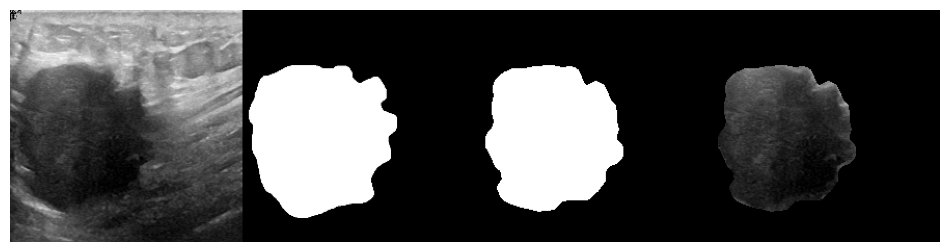

 Epoch: 71 of 100, Iter.: 16 of 16, Train Loss: 0.031937, IoU: 0.963134, Dice: 0.981077
 Epoch: 71 of 100, Iter.: 16 of 16, Valid Loss: 0.592458, IoU: 0.589584, Dice: 0.703287


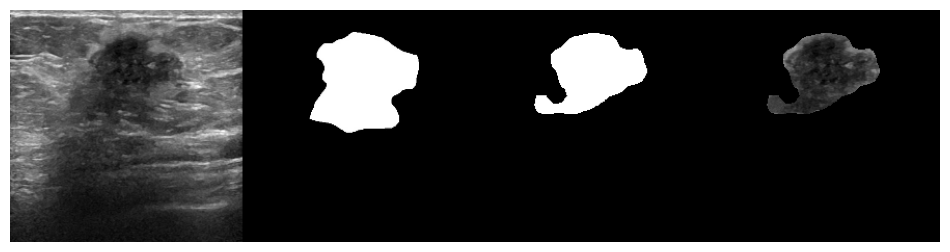

 Epoch: 72 of 100, Iter.: 16 of 16, Train Loss: 0.032498, IoU: 0.963520, Dice: 0.981317
 Epoch: 72 of 100, Iter.: 16 of 16, Valid Loss: 0.583535, IoU: 0.592618, Dice: 0.706647


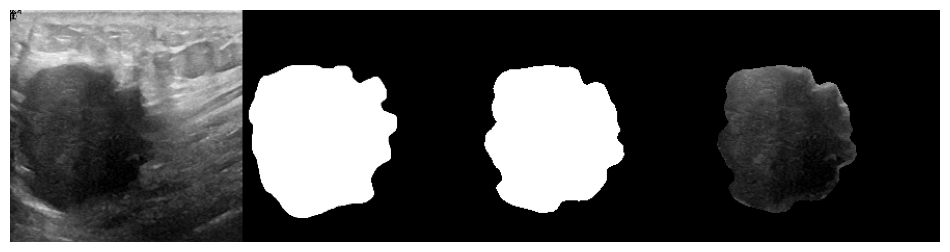

 Epoch: 73 of 100, Iter.: 16 of 16, Train Loss: 0.031565, IoU: 0.963447, Dice: 0.981278
 Epoch: 73 of 100, Iter.: 16 of 16, Valid Loss: 0.597516, IoU: 0.588079, Dice: 0.701204


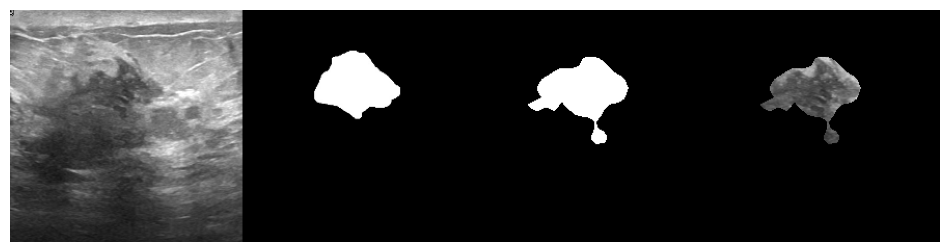

 Epoch: 74 of 100, Iter.: 16 of 16, Train Loss: 0.033466, IoU: 0.962039, Dice: 0.980528
 Epoch: 74 of 100, Iter.: 16 of 16, Valid Loss: 0.588814, IoU: 0.585999, Dice: 0.699290


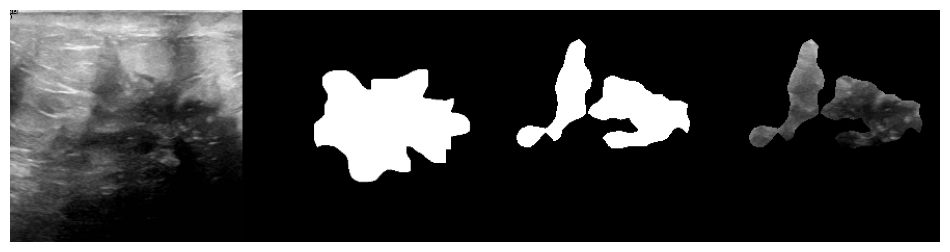

 Epoch: 75 of 100, Iter.: 16 of 16, Train Loss: 0.032791, IoU: 0.962161, Dice: 0.980599
 Epoch: 75 of 100, Iter.: 16 of 16, Valid Loss: 0.585736, IoU: 0.598993, Dice: 0.712235


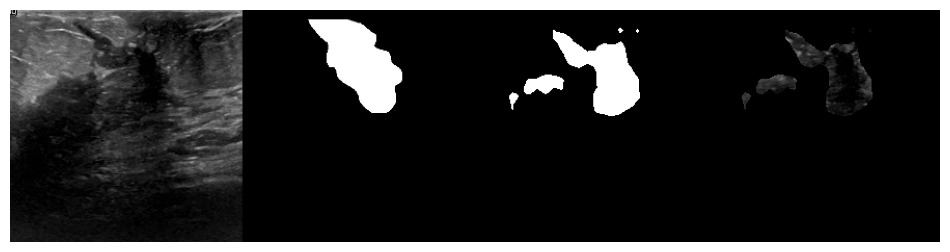

 Epoch: 76 of 100, Iter.: 16 of 16, Train Loss: 0.031180, IoU: 0.963782, Dice: 0.981436
 Epoch: 76 of 100, Iter.: 16 of 16, Valid Loss: 0.593927, IoU: 0.592883, Dice: 0.706947


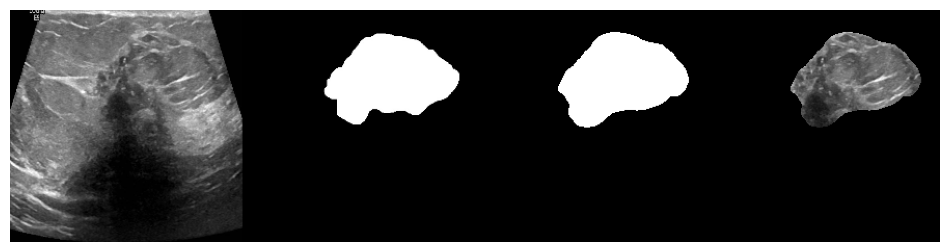

 Epoch: 77 of 100, Iter.: 16 of 16, Train Loss: 0.031715, IoU: 0.965074, Dice: 0.982124
 Epoch: 77 of 100, Iter.: 16 of 16, Valid Loss: 0.595232, IoU: 0.593052, Dice: 0.706446


 Epoch: 78 of 100, Iter.: 16 of 16, Train Loss: 0.030230, IoU: 0.964522, Dice: 0.981832
 Epoch: 78 of 100, Iter.: 16 of 16, Valid Loss: 0.615334, IoU: 0.584527, Dice: 0.699860


 Epoch: 79 of 100, Iter.: 16 of 16, Train Loss: 0.030528, IoU: 0.966122, Dice: 0.982690
 Epoch: 79 of 100, Iter.: 16 of 16, Valid Loss: 0.591688, IoU: 0.598558, Dice: 0.711568


 Epoch: 80 of 100, Iter.: 16 of 16, Train Loss: 0.030174, IoU: 0.965137, Dice: 0.982163
 Epoch: 80 of 100, Iter.: 16 of 16, Valid Loss: 0.603375, IoU: 0.592809, Dice: 0.706807


 Epoch: 81 of 100, Iter.: 16 of 16, Train Loss: 0.029644, IoU: 0.966162, Dice: 0.982701
 Epoch: 81 of 100, Iter.: 16 of 16, Valid Loss: 0.584561, IoU: 0.598869, Dice: 0.712180


 Epoch: 82 of 100, Iter.: 16 of 16, Train Loss: 0.028994, IoU: 0.966335, Dice: 0.982749
 Epoch: 82 of 100, Iter.: 16 of 16, Valid Loss: 0.605531, IoU: 0.589289, Dice: 0.704196


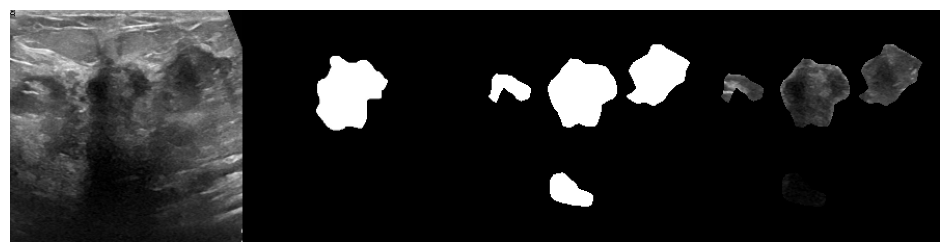

 Epoch: 83 of 100, Iter.: 16 of 16, Train Loss: 0.028178, IoU: 0.965908, Dice: 0.982327
 Epoch: 83 of 100, Iter.: 16 of 16, Valid Loss: 0.598357, IoU: 0.593440, Dice: 0.706609


 Epoch: 84 of 100, Iter.: 16 of 16, Train Loss: 0.027085, IoU: 0.968686, Dice: 0.984005
 Epoch: 84 of 100, Iter.: 16 of 16, Valid Loss: 0.591356, IoU: 0.594654, Dice: 0.708540


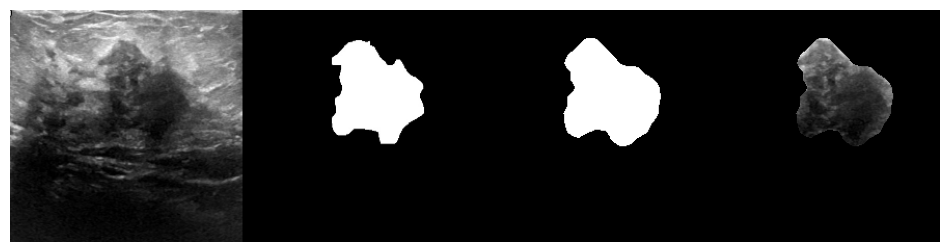

 Epoch: 85 of 100, Iter.: 16 of 16, Train Loss: 0.026625, IoU: 0.970388, Dice: 0.984891
 Epoch: 85 of 100, Iter.: 16 of 16, Valid Loss: 0.611584, IoU: 0.592798, Dice: 0.706906


 Epoch: 86 of 100, Iter.: 16 of 16, Train Loss: 0.026200, IoU: 0.969356, Dice: 0.984360
 Epoch: 86 of 100, Iter.: 16 of 16, Valid Loss: 0.593636, IoU: 0.595163, Dice: 0.708724


 Epoch: 87 of 100, Iter.: 16 of 16, Train Loss: 0.025947, IoU: 0.970989, Dice: 0.985206
 Epoch: 87 of 100, Iter.: 16 of 16, Valid Loss: 0.617342, IoU: 0.592371, Dice: 0.706944


 Epoch: 88 of 100, Iter.: 16 of 16, Train Loss: 0.026857, IoU: 0.969458, Dice: 0.984416
 Epoch: 88 of 100, Iter.: 16 of 16, Valid Loss: 0.613131, IoU: 0.587852, Dice: 0.703056


 Epoch: 89 of 100, Iter.: 16 of 16, Train Loss: 0.026811, IoU: 0.968205, Dice: 0.983738
 Epoch: 89 of 100, Iter.: 16 of 16, Valid Loss: 0.618824, IoU: 0.589462, Dice: 0.703435


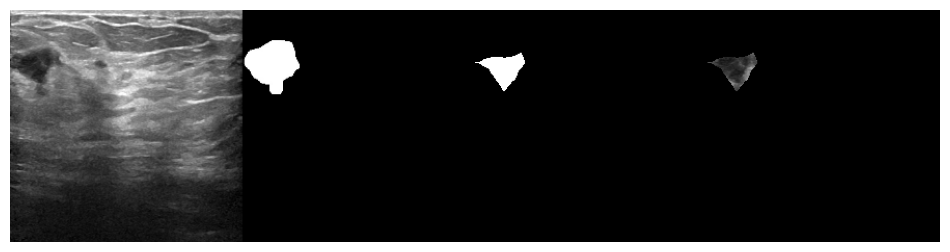

 Epoch: 90 of 100, Iter.: 16 of 16, Train Loss: 0.027092, IoU: 0.969849, Dice: 0.984620
 Epoch: 90 of 100, Iter.: 16 of 16, Valid Loss: 0.615908, IoU: 0.591460, Dice: 0.706059


 Epoch: 91 of 100, Iter.: 16 of 16, Train Loss: 0.025297, IoU: 0.970591, Dice: 0.985003
 Epoch: 91 of 100, Iter.: 16 of 16, Valid Loss: 0.620200, IoU: 0.592649, Dice: 0.706631


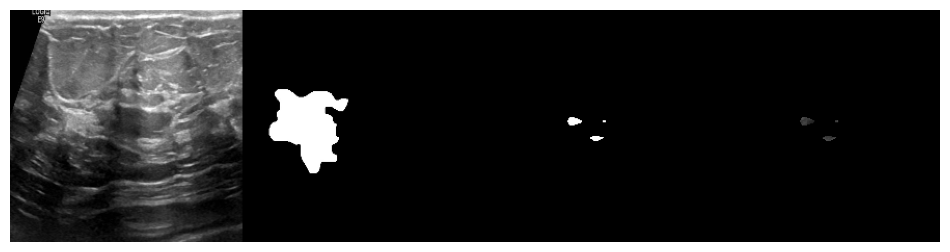

 Epoch: 92 of 100, Iter.: 16 of 16, Train Loss: 0.025058, IoU: 0.971505, Dice: 0.985477
 Epoch: 92 of 100, Iter.: 16 of 16, Valid Loss: 0.617776, IoU: 0.594192, Dice: 0.708479


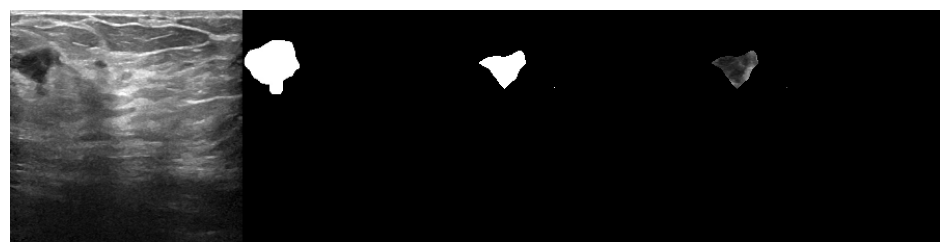

 Epoch: 93 of 100, Iter.: 16 of 16, Train Loss: 0.025644, IoU: 0.971363, Dice: 0.985397
 Epoch: 93 of 100, Iter.: 16 of 16, Valid Loss: 0.617950, IoU: 0.595132, Dice: 0.709079


 Epoch: 94 of 100, Iter.: 16 of 16, Train Loss: 0.024295, IoU: 0.971215, Dice: 0.985323
 Epoch: 94 of 100, Iter.: 16 of 16, Valid Loss: 0.632824, IoU: 0.588850, Dice: 0.703479


 Epoch: 95 of 100, Iter.: 16 of 16, Train Loss: 0.024522, IoU: 0.971806, Dice: 0.985636
 Epoch: 95 of 100, Iter.: 16 of 16, Valid Loss: 0.632265, IoU: 0.587286, Dice: 0.701119


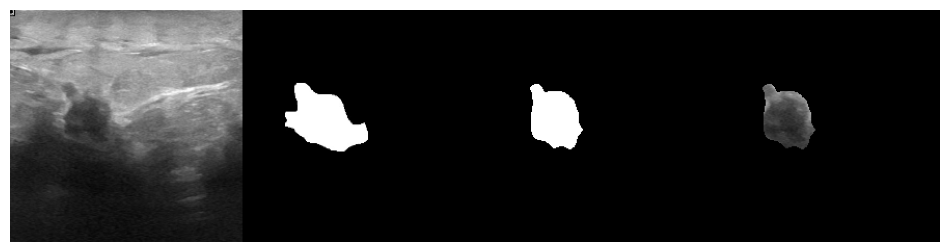

 Epoch: 96 of 100, Iter.: 16 of 16, Train Loss: 0.024426, IoU: 0.971902, Dice: 0.985675
 Epoch: 96 of 100, Iter.: 16 of 16, Valid Loss: 0.614944, IoU: 0.595565, Dice: 0.709762


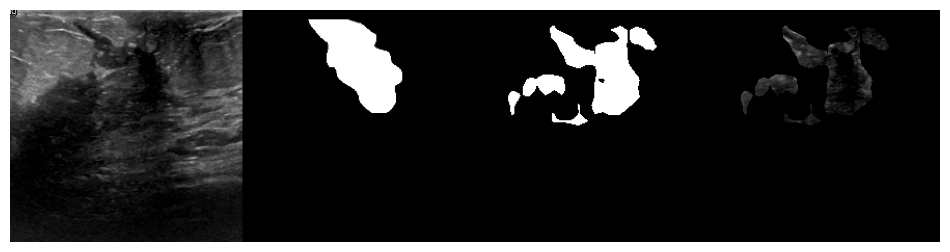


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 6min 5s, sys: 6min 53s, total: 12min 59s
Wall time: 5min 50s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:75, Best_IOU:0.5990, Best_DiceScore:0.7122


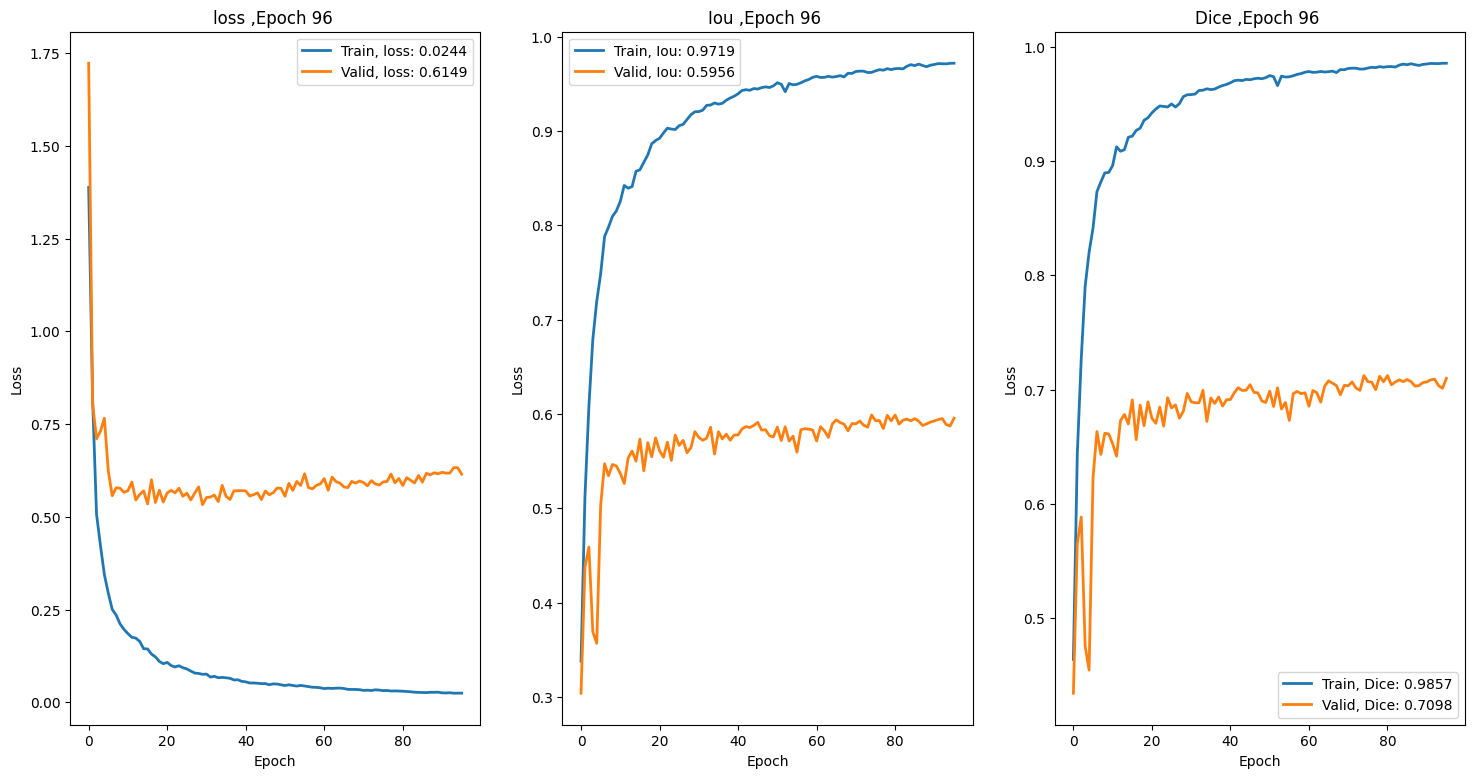

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()